In [ ]:
#import all relevant packages

import pandas as pd
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import KMeansSMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from statsmodels.tools.tools import add_constant
from google.colab import files
import seaborn as sns

In [ ]:
#import and read the dataset
#os.chdir("/clean_BNPL_clients.csv")

bnpl = pd.read_csv('clean_BNPL_python.csv')

#define a function to convert category features into numerical

def encode_categoricals(df, categorical_features):
  for col in categorical_features:
    df[col] = df[col].astype("category").cat.codes
  return df

#identify the numerical categories

bnpl_continuous = bnpl[['loan_amnt', 'int_rate', 'monthly_payment', 'annual_inc', 'total_dti', 'tot_coll_amt', 'tot_cur_bal', \
                                  'total_bal_ex_mort','credit_limit']]

#identify categorical categories

bnpl_categor = bnpl[['loan_term', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_purpose', \
                               'delinq_2yrs', 'open_acc','addr_state', 'application_type', 'cur_acct_delinq', 'mort_acc', \
                               'num_accts_120_pd', 'pub_rec_bankruptcies', 'tax_liens', 'hardship_flag', 'disbursement_method', \
                               'debt_settlement_flag']]
#source the column indices
bnpl_categor_indx = [bnpl.columns.get_loc(col) for col in bnpl_categor]

#use the encoding function to convert the string variables into numerical

bnpl_num = encode_categoricals(bnpl, bnpl_categor)

#enact one-hot encoding
bnpl_num = pd.get_dummies(bnpl_num, columns=bnpl_categor.columns,
                          prefix = bnpl_categor.columns)

#split the data into training and test sets

bnpl_att = bnpl_num.drop(['loan_status'], axis=1)
bnpl_tar = bnpl_num['loan_status']

from sklearn.model_selection import train_test_split

bnpl_att_train, bnpl_att_test, bnpl_tar_train, bnpl_tar_test = train_test_split(bnpl_att, bnpl_tar, test_size=0.3, random_state=55)

#resample the data with SMOTE, which will go on to be used in the models

from imblearn.over_sampling import SMOTE
bnpl_smote = SMOTE(random_state=1000)

bnpl_train_att_resample, bnpl_train_tar_resample = bnpl_smote.fit_resample(bnpl_att_train, bnpl_tar_train)

#resample the data with k-means SMOTE methods

from imblearn.over_sampling import KMeansSMOTE
bnpl_KMsmote = KMeansSMOTE(random_state=1000, cluster_balance_threshold=0.1, kmeans_estimator=30)

bnpl_train_att_KM_resample, bnpl_train_tar_KM_resample = bnpl_KMsmote.fit_resample(bnpl_att_train, bnpl_tar_train)

In [ ]:
#develop a logistic regression model for a baseline model the experimental models will be compared to

scaler = MinMaxScaler()
bnpl_train_att_scaled = scaler.fit_transform(bnpl_train_att_resample)

#initialize log reg model
bnpl_log_reg = LogisticRegression()

lgrg_cv_scores = cross_val_score(bnpl_log_reg, bnpl_train_att_scaled, bnpl_train_tar_resample, cv= 5, scoring ="accuracy")

print("Cross-Validation Accuracy Scores on Training Set:", lgrg_cv_scores)
print("Average Cross-Validation Accuracy on Training Set:", lgrg_cv_scores.mean())

Cross-Validation Accuracy Scores on Training Set: [0.8002103  0.99967138 0.99953993 0.99967138 0.9994742 ]
Average Cross-Validation Accuracy on Training Set: 0.9597134379190937


In [ ]:
#train the model on the full dataset

bnpl_log_reg.fit(bnpl_train_att_scaled, bnpl_train_tar_resample)

#scale the test attributes
bnpl_test_att_scaled = scaler.fit_transform(bnpl_att_test)

tar_pred_test_lgrg = bnpl_log_reg.predict(bnpl_test_att_scaled)

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

lgrg_testaccuracy = accuracy_score(bnpl_tar_test, tar_pred_test_lgrg)
sensitivity = recall_score(bnpl_tar_test, tar_pred_test_lgrg, pos_label='solvent')
specificity = recall_score(bnpl_tar_test, tar_pred_test_lgrg, pos_label='default')
conf_matrix = confusion_matrix(bnpl_tar_test, tar_pred_test_lgrg)

# Output the results
print("Confusion Matrix:\n", conf_matrix)
print("Test Accuracy:", lgrg_testaccuracy)
print("Sensitivity (Recall for Default):", sensitivity)
print("Specificity (Recall for Solvent):", specificity)

Confusion Matrix:
 [[  186  1202]
 [    6 16322]]
Test Accuracy: 0.9318130503499661
Sensitivity (Recall for Default): 0.9996325330720235
Specificity (Recall for Solvent): 0.1340057636887608


In [ ]:
# Extract TP, FP, TN, FN from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()
print("True Negatives (TN):", tn)
print("False Positives (FP):", fp)
print("False Negatives (FN):", fn)
print("True Positives (TP):", tp)

True Negatives (TN): 186
False Positives (FP): 1202
False Negatives (FN): 6
True Positives (TP): 16322


<Axes: >

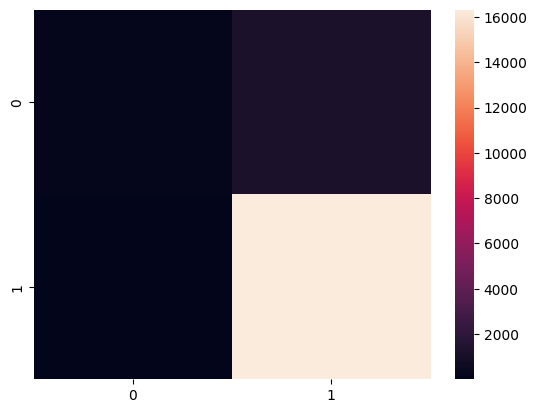

In [ ]:
sns.heatmap(conf_matrix)

# Repeat with KMSMOTE

In [ ]:
bnpl_train_att_KM_scaled = scaler.fit_transform(bnpl_train_att_KM_resample)

#initialize log reg model
bnpl_log_reg = LogisticRegression()

lgrg_cv_scores_KM = cross_val_score(bnpl_log_reg, bnpl_train_att_KM_scaled, bnpl_train_tar_KM_resample, cv= 5, scoring ="accuracy")

print("Cross-Validation Accuracy Scores on Training Set:", lgrg_cv_scores_KM)
print("Average Cross-Validation Accuracy on Training Set:", lgrg_cv_scores_KM.mean())

Cross-Validation Accuracy Scores on Training Set: [0.80153775 0.99973714 0.99980285 0.99973714 0.99953999]
Average Cross-Validation Accuracy on Training Set: 0.9600709732535979


In [ ]:
#train the model on the full dataset

bnpl_log_reg.fit(bnpl_train_att_KM_scaled, bnpl_train_tar_KM_resample)

tar_pred_test_lgrg = bnpl_log_reg.predict(bnpl_test_att_scaled)

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

lgrg_testaccuracy = accuracy_score(bnpl_tar_test, tar_pred_test_lgrg)
sensitivity = recall_score(bnpl_tar_test, tar_pred_test_lgrg, pos_label='solvent')
specificity = recall_score(bnpl_tar_test, tar_pred_test_lgrg, pos_label='default')
conf_matrix = confusion_matrix(bnpl_tar_test, tar_pred_test_lgrg)

# Output the results
print("Confusion Matrix:\n", conf_matrix)
print("Test Accuracy:", lgrg_testaccuracy)
print("Sensitivity (Recall for Solvent):", sensitivity)
print("Specificity (Recall for Default):", specificity)

Confusion Matrix:
 [[  186  1202]
 [    5 16323]]
Test Accuracy: 0.9318694965003387
Sensitivity (Recall for Solvent): 0.9996937775600196
Specificity (Recall for Default): 0.1340057636887608


In [ ]:
# Extract TP, FP, TN, FN from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()
print("True Negatives (TN):", tn)
print("False Positives (FP):", fp)
print("False Negatives (FN):", fn)
print("True Positives (TP):", tp)

True Negatives (TN): 186
False Positives (FP): 1202
False Negatives (FN): 5
True Positives (TP): 16323


<Axes: >

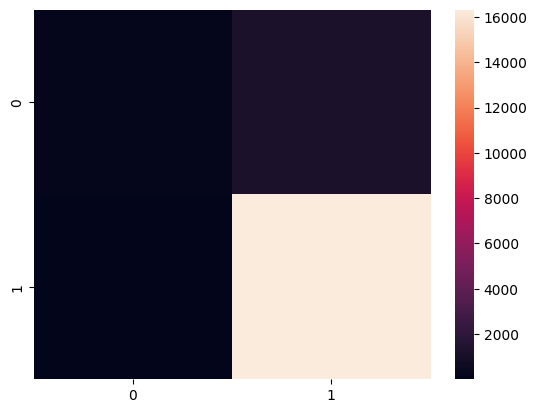

In [ ]:
sns.heatmap(conf_matrix)